## Outline

Following features of impulse response simulator have been implemented in this notebook.

1- Find lag-frequency spectrum of a simple delta impulse response.

2- Find lag-frequency spectrum of a _more_ realistic impulse response based on real physical principles.

3- Compute lag-frequency spectrum of delta impulse responses with same intensities and varying positions at different energy levels.

4- Compute lag-frequency spectrum of delta impulse responses with same positions and varying intensities at different energy levels.

Import libraries and obtain data.

In [1]:
from stingray import Crossspectrum, Lightcurve, sampledata
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

%matplotlib inline

Define variability signal.

In [2]:
lc = sampledata.sample_data()
s = lc.counts

## Lag-frequency Spectrum

### Simple Delta Impulse Response

Define a delta impulse response with a delay of 10.

In [3]:
delay = int(10/lc.dt)
h_zeros = np.zeros(delay)
h = np.append(h_zeros, 1)

Find output signal by taking convolution of variability signal and impulse response.

In [4]:
output = signal.fftconvolve(s, h)
# To make two counts of equal size, remove last 'delay' entries and avoid first zeros
output = output[delay:-delay]
s_mod = s[delay:]

Visualize input and output signals.

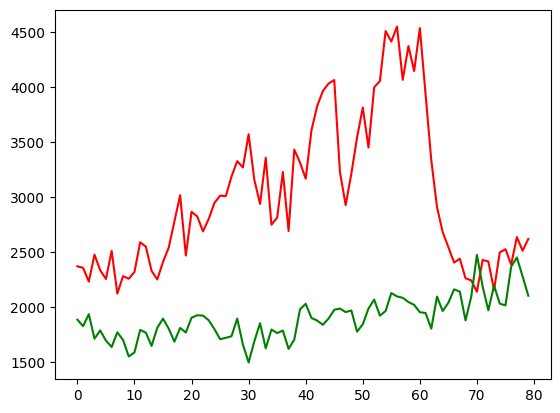

In [5]:
plt.figure()
plt.plot(s_mod[-80:],'r',output[-80:],'g')
plt.show()

Make lightcurves using `Lightcurve` class.

In [6]:
time = lc.time[delay:]
lc1 = Lightcurve(time, s_mod)
lc2 = Lightcurve(time, output)

Compute crossspectrum.

In [7]:
cross = Crossspectrum(lc2, lc1)
# Rebin the cross spectrum for ease of visualization
cross = cross.rebin(0.0075)

Calculate time lag.

In [8]:
lag = np.angle(cross.power)/ (2 * np.pi * cross.freq)

Plot lag.

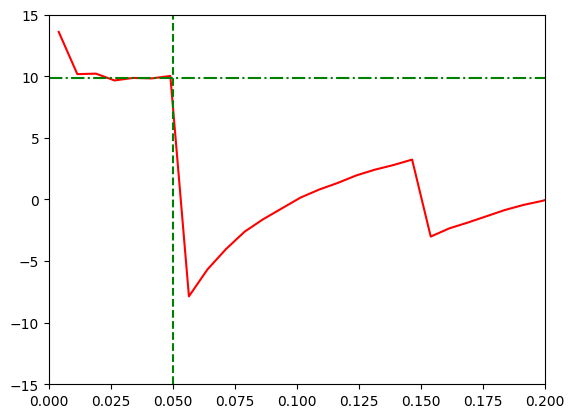

In [9]:
plt.figure()

# Plot lag-frequency spectrum.
plt.plot(cross.freq, lag, 'r')

# Find cutoff points
v_cutoff = 1.0/(2*10.0)
h_cutoff = lag[int((v_cutoff-0.0075)*1/0.0075)]

plt.axvline(v_cutoff, color='g',linestyle='--')
plt.axhline(h_cutoff, color='g', linestyle='-.')

# Define axis
plt.axis([0,0.2,-15,15])
plt.show()

According to Uttley et al, the lag-frequency spectrum shows a constant delay until the frequency (1/2*time_delay) which is represented by the green vertical line in the above figure. After this point, the phase warps and the lag becomes negative. This is given in page 43 of review.

### More realistic impulse response

The response of refelection from an accretion disk to an instantaneous flash follows the _top-hat function_ to first
order approximation. The response shows an initial steep rise some time after the initial flash (slope depending on
the light travel time to the disk) and then gradually decays, as parts of the accretion disk farther away from the 
source receieve radiations at later times.

The secondary peak is caused due to the bending of light in strong gravitational field around the black hole. This is the re-emergence of photons reflected from the far side of accretion disk that although would be classically blocked from our view, are lensed by strong gravitational field around black hole into our line of sight. 

Below, we obtain an impulse response similar to one in Utley et al.


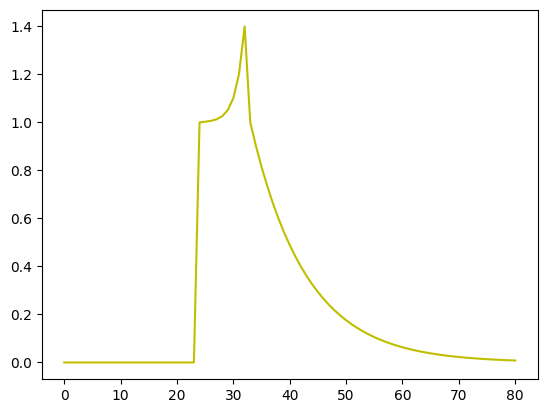

In [10]:
# Primary peak time, secondary peak time, end time
t1, t2, t3 = 3, 4, 10
# Peaks' values
p1, p2 = 1, 1.4
# Rise and decay slopes
rise, decay = 0.6, 0.1

# Append zeros before start time
h_primary = np.append(np.zeros(int(t1/lc.dt)), p1)

# Create a rising exponential of user-provided slope that ends at secondary peak time and secondary peak
# value
x = np.linspace(int(t1/lc.dt), int(t2/lc.dt), int((t2-t1)/lc.dt))
h_rise = np.exp(rise*x)
# Find a factor for scaling
factor = np.max(h_rise)/(p2-p1)
h_secondary = (h_rise/factor) + p1

# Create a decaying exponential until the end time
x = np.linspace(int(t2/lc.dt), int(t3/lc.dt), int((t3-t2)/lc.dt))
h_decay = (np.exp((-decay)*(x-4/lc.dt)))

# Add the three responses
h = np.append(h_primary, h_secondary)
h = np.append(h, h_decay)

# Plot
plt.plot(h,'y')
plt.show()


Obtain output through convolution.

In [11]:
delay = (int(t3/lc.dt))
output = signal.fftconvolve(s, h)
output = output[delay:-delay]
s_mod = s[delay:]

Form light curves.

In [12]:
time = lc.time[delay:]
lc1 = Lightcurve(time, s_mod)
lc2 = Lightcurve(time, output)

Find cross spectrum and compute lags.

In [13]:
cross = Crossspectrum(lc2, lc1)
cross = cross.rebin(0.0075)
lag = np.angle(cross.power)/ (2 * np.pi * cross.freq)

Plot results.

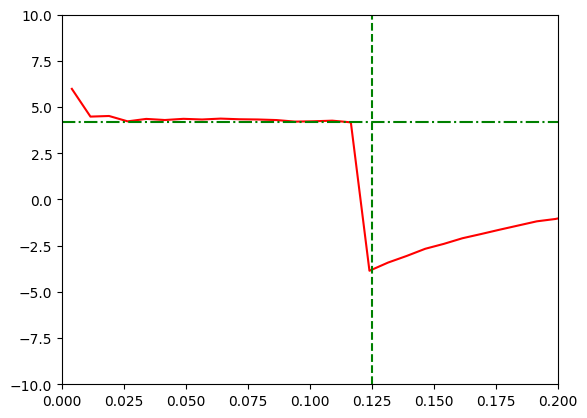

In [14]:
plt.figure()

# Plot lag-frequency spectrum.
plt.plot(cross.freq, lag, 'r')

# Define the x-position of vertical line
v_cutoff = 1.0/(2*t2)
h_cutoff = lag[int((v_cutoff-0.0075)*1/0.0075)]

plt.axvline(v_cutoff, color='g', linestyle='--')
plt.axhline(h_cutoff, color='g', linestyle='-.')

# Define axis
plt.axis([0,0.2,-10,10])
plt.show()

## Energy Dependence

### With same intensity and varying position

To create different lags for different energy channels, we create delta impulses of same intensity at different positions.

In [15]:
energies = np.array([4.5,8.5])

Create impulse responses for all energy channels.

In [16]:
h_zeros = [np.zeros(int(i/lc.dt)) for i in energies]
responses = [np.append(h, 1) for h in h_zeros]

In [17]:
delays = [int(i/lc.dt) for i in energies]
outputs = [signal.fftconvolve(s, h)[d:-d] for h,d in zip(responses,delays)]
s_mods = [s[d:] for d in delays]

Make light curves.

In [18]:
t_mods = [lc.time[d:] for d in delays]
lc_input = [Lightcurve(t_mod, s_mod) for t_mod, s_mod in zip(t_mods,s_mods)]
lc_output = [Lightcurve(t_mod, output) for t_mod, output in zip(t_mods,outputs)]

In [19]:
cross_spectrums = [Crossspectrum(lc2, lc1).rebin(0.0075) for lc1,lc2 in zip(lc_input,lc_output)]

Compute lags and cutoffs.

In [20]:
lags = [np.angle(cross.power)/ (2 * np.pi * cross.freq) for cross in cross_spectrums]

Get cutoff points for all energy channels.

In [21]:
v_cutoffs = [1.0/(2*energy) for energy in energies]
h_cutoffs = [lag[int((v_cutoff-0.0075)*1/0.0075)] for lag, v_cutoff in zip(lags, v_cutoffs)]

We plot lag-frequency spectrum for all energy channels.

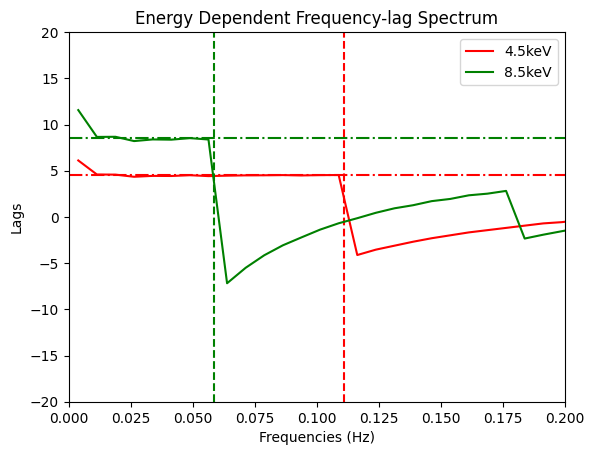

In [22]:
plt.figure()
plots = []
colors = ['r','g']

# Plot lag-frequency spectrum
for i in range(0,len(lags)):
    plots += plt.plot(cross_spectrums[i].freq, lags[i], colors[i], label=str(energies[i])+'keV')
    plt.axvline(v_cutoffs[i],color=colors[i],linestyle='--')
    plt.axhline(h_cutoffs[i], color=colors[i], linestyle='-.')

# Define axes and add labels
plt.axis([0,0.2,-20,20])
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Lags')
plt.title('Energy Dependent Frequency-lag Spectrum')
plt.show()

Note:

Currently, lag-energy spectrum isn't plotted and hence I am unable to verify results from Uttley et al. However, as soon as it is implemented in library project, I will test it here as well.

### With same position and varying intensity

Here, we use delta impulse responses whose position remains same but intensity varies. 

Again, first we define energies and then create impulse responses, and subsequently using convolution, obtain the output light curves.

In [23]:
energies = np.array([4.5,8.5])

In [24]:
h_zeros = np.zeros(int(10/lc.dt))
responses = [np.append(h_zeros, i+1) for i in range(0,len(energies))]

In [25]:
delay = int(10/lc.dt)
outputs = [signal.fftconvolve(s, h)[delay:-delay] for h in responses]
s_mod = s[delay:]

In [26]:
t_mod = lc.time[delay:]
lc_input = Lightcurve(t_mod, s_mod)
lc_output = [Lightcurve(t_mod, output) for output in outputs]

In [27]:
cross_spectrums = [Crossspectrum(lc2, lc_input).rebin(0.0075) for lc2 in lc_output]

In [28]:
lags = [np.angle(cross.power)/ (2 * np.pi * cross.freq) for cross in cross_spectrums]

In [29]:
v_cutoff = 1.0/(2.0*10)
h_cutoff = lags[0][int((v_cutoff-0.0075)*1/0.0075)]

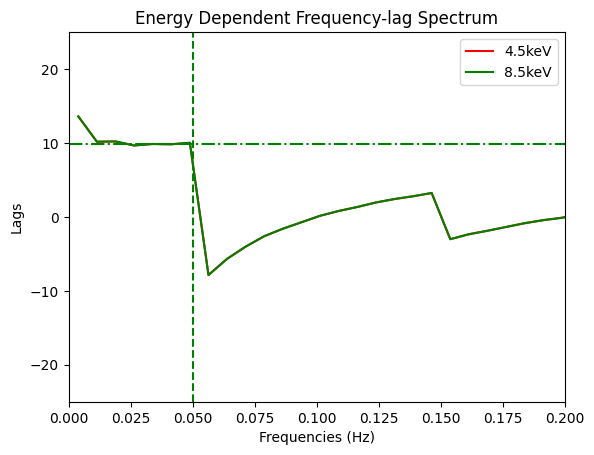

In [30]:
plt.figure()
plots = []
colors = ['r','g']

# Plot lag-frequency spectrum
for i in range(0,len(lags)):
    plots += plt.plot(cross_spectrums[i].freq, lags[i], colors[i], label=str(energies[i])+'keV')

# Draw horizontal and vertical line
plt.axvline(v_cutoff, color='g', linestyle='--')
plt.axhline(h_cutoff, color='g', linestyle='-.')


# Define axis
plt.axis([0,0.2,-25,25])
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Lags')
plt.title('Energy Dependent Frequency-lag Spectrum')
plt.show()

As expected (and also demonstrated in Utley et al), the shape of lag-frequency spectrum for both energy channels is similar.
